In [1]:
import urllib

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
print("Loading data")
ng_data = fetch_20newsgroups(subset='train')

Loading data


In [3]:
data_target = ng_data.target
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_transformed_data = tfidf_vectorizer.fit_transform(ng_data.data)
train_data = tfidf_transformed_data.toarray().T

In [4]:
url = "http://qwone.com/~jason/20Newsgroups/vocabulary.txt"
vocab_file = urllib.request.urlopen(url)

vocab_dict = {}
i = 0
for line in vocab_file:
    vocab_dict[i] = line.decode("utf-8")
    i = i + 1

### a) LSI/PCA via orthogonal iteration.

PCA using orthogonal iteration method for k=2


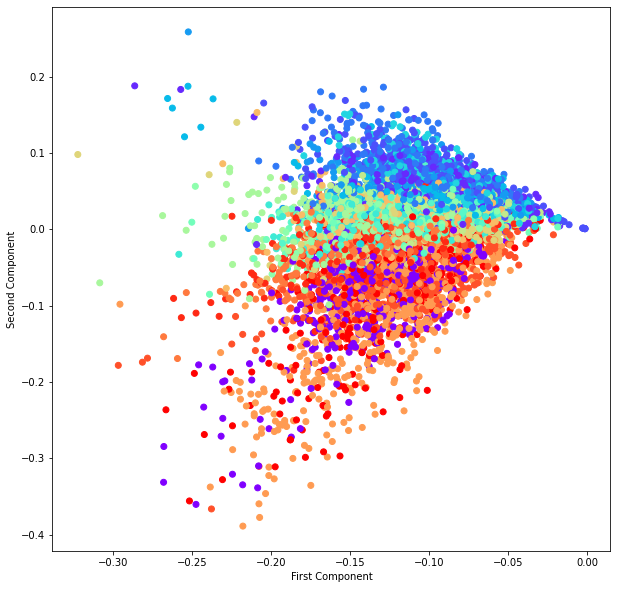

In [5]:
print("PCA using orthogonal iteration method for k=2")
f, d = train_data.shape
# k=4
theta = np.random.rand(f, 2)
prev_theta = np.random.rand(f, 2)

while (prev_theta != theta).all():
    prev_theta = theta
    mat = train_data.T.dot(theta)
    mat = train_data.dot(mat)
    theta, eigen_vecs = np.linalg.qr(mat)

X_train_pca = train_data.T.dot(theta)

plt.figure(figsize=(10, 10))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=data_target, cmap=cm.rainbow)
plt.xlabel('First Component')
plt.ylabel('Second Component')
plt.show()

### b) LSI/PCA via orthogonal iteration.

In [6]:
print("PCA using orthogonal iteration method for k=100")
k = 100  # K_LSI
f, d = train_data.shape
theta = np.random.rand(f, k)
prev_theta = np.random.rand(f, k)

while ((prev_theta != theta).all()):
    prev_theta = theta
    mat = train_data.T.dot(theta)
    mat = train_data.dot(mat)
    theta, eigen_vecs = np.linalg.qr(mat)

X_train_pca = train_data.T.dot(theta)

Part B
PCA using orthogonal iteration method for k=100


In [7]:
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal as mvn

In [8]:
class GMM:
    def __init__(self, C, n_runs):
        self.C = C
        self.n_runs = n_runs

    def get_params(self):
        return self.mu, self.pi, self.sigma

    def calculate_mean_covariance(self, X, prediction):
        d = X.shape[1]
        labels = np.unique(prediction)
        self.initial_means = np.zeros((self.C, d))
        self.initial_cov = np.zeros((self.C, d, d))
        self.initial_pi = np.zeros(self.C)

        counter = 0
        for label in labels:
            ids = np.where(prediction == label)
            self.initial_pi[counter] = len(ids[0]) / X.shape[0]
            self.initial_means[counter, :] = np.mean(X[ids], axis=0)
            de_meaned = X[ids] - self.initial_means[counter, :]
            Nk = X[ids].shape[0]
            self.initial_cov[counter, :, :] = np.dot(self.initial_pi[counter] * de_meaned.T, de_meaned) / Nk
            counter += 1
        assert np.sum(self.initial_pi) == 1

        return (self.initial_means, self.initial_cov, self.initial_pi)

    def _initialise_parameters(self, X):
        n_clusters = self.C
        kmeans = KMeans(n_clusters=n_clusters, init="k-means++", max_iter=500, algorithm='auto')
        fitted = kmeans.fit(X)
        prediction = kmeans.predict(X)
        self._initial_means, self._initial_cov, self._initial_pi = self.calculate_mean_covariance(X, prediction)

        return (self._initial_means, self._initial_cov, self._initial_pi)

    def _e_step(self, X, pi, mu, sigma):
        N = X.shape[0]
        self.gamma = np.zeros((N, self.C))

        const_c = np.zeros(self.C)

        self.mu = self.mu if self._initial_means is None else self._initial_means
        self.pi = self.pi if self._initial_pi is None else self._initial_pi
        self.sigma = self.sigma if self._initial_cov is None else self._initial_cov

        for c in range(self.C):
            self.gamma[:, c] = self.pi[c] * mvn.pdf(X, self.mu[c, :], self.sigma[c])

        gamma_norm = np.sum(self.gamma, axis=1)[:, np.newaxis]
        self.gamma /= gamma_norm

        return self.gamma

    def _m_step(self, X, gamma):
        N = X.shape[0]
        C = self.gamma.shape[1]
        d = X.shape[1]

        self.pi = np.mean(self.gamma, axis=0)

        self.mu = np.dot(self.gamma.T, X) / np.sum(self.gamma, axis=0)[:, np.newaxis]

        for c in range(C):
            x = X - self.mu[c, :]

            gamma_diag = np.diag(self.gamma[:, c])
            x_mu = np.matrix(x)
            gamma_diag = np.matrix(gamma_diag)

            sigma_c = x.T * gamma_diag * x
            self.sigma[c, :, :] = (sigma_c) / np.sum(self.gamma, axis=0)[:, np.newaxis][c]

        return self.pi, self.mu, self.sigma

    def _compute_loss_function(self, X, pi, mu, sigma):
        N = X.shape[0]
        C = self.gamma.shape[1]
        self.loss = np.zeros((N, C))

        for c in range(C):
            dist = mvn(self.mu[c], self.sigma[c], allow_singular=True)
            self.loss[:, c] = self.gamma[:, c] * (
                    np.log(self.pi[c] + 0.00001) + dist.logpdf(X) - np.log(self.gamma[:, c] + 0.000001))
        self.loss = np.sum(self.loss)
        return self.loss

    def fit(self, X):
        d = X.shape[1]
        self.mu, self.sigma, self.pi = self._initialise_parameters(X)

        try:
            for run in range(self.n_runs):
                self.gamma = self._e_step(X, self.mu, self.pi, self.sigma)
                self.pi, self.mu, self.sigma = self._m_step(X, self.gamma)
                loss = self._compute_loss_function(X, self.pi, self.mu, self.sigma)

        except Exception as e:
            print(e)

        return self

    def predict(self, X):

        labels = np.zeros((X.shape[0], self.C))

        for c in range(self.C):
            labels[:, c] = self.pi[c] * mvn.pdf(X, self.mu[c, :], self.sigma[c], allow_singular=True)
        labels = labels.argmax(1)
        return labels

In [9]:
model = GMM(20, n_runs=1000)

fitted_values = model.fit(X_train_pca)

singular matrix


In [10]:
predicted_values = model.predict(X_train_pca)

centers = np.zeros((20, 100))
for i in range(model.C):
    density = mvn(cov=model.sigma[i], mean=model.mu[i], allow_singular=True).logpdf(X_train_pca)
    centers[i, :] = X_train_pca[np.argmax(density)]

print(X_train_pca.shape)
print(centers.shape)

(11314, 100)
(20, 100)


In [14]:
theta_mean = np.matmul(X_train_pca, centers.transpose())

result = []
for i in range(20):
    temp = theta_mean[:, i]
    temp_index = temp.argsort()[-10:][::-1]
    print("Top 10 key words for cluster:", i)
    for j in temp_index:
        print(vocab_dict[j])

Top 10 key words for cluster: 0
und

noticing

seldom

flipping

blindly

citizens

nf

pull

virginia

defenceless

Top 10 key words for cluster: 1
peculiar

area

dismissively

mchp

aesthetics

games

point

wpd

conveniently

adolescents

Top 10 key words for cluster: 2
worthy

keresh

incas

drastically

electrons

deviant

situiations

umm

heavy

propogation

Top 10 key words for cluster: 3
gaul

explaining

persecution

colour

moslems

hannover

nine

curiously

ooo

honor

Top 10 key words for cluster: 4
necessity

nrp

exist

coincidence

fri

shits

innermost

creatures

paradoxes

rusnews

Top 10 key words for cluster: 5
fri

coincidence

arrived

hanse

oral

necessity

invented

grass

nrp

desolate

Top 10 key words for cluster: 6
led

loan

bitmaps

rashid

dietary

environmental

possible

hatching

ellipses

neurons

Top 10 key words for cluster: 7
koran

creatures

extension

diag

falls

infinity

guessed

excommunicated

senior

suprised

Top 10 key words for clus

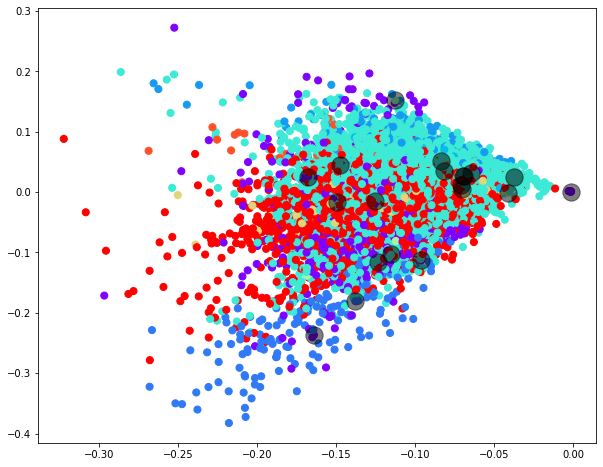

In [15]:
plt.figure(figsize=(10, 8))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=predicted_values, s=50, cmap=cm.rainbow, zorder=1)

plt.scatter(centers[:, 0], centers[:, 1], c='black', s=300, alpha=0.5, zorder=2)

In [12]:
from sklearn.mixture import GaussianMixture

In [16]:
model = GaussianMixture(n_components=20, covariance_type='full')
output = model.fit(X_train_pca)
mean = model.means_

/Users/anurags/miniforge3/envs/tensorflow_exp/lib/python3.9/site-packages/sklearn/mixture/_base.py:277: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


In [17]:
theta_mean = np.matmul(X_train_pca, mean.transpose())

result = []
for i in range(20):
    temp = theta_mean[:, i]
    temp_index = temp.argsort()[-10:][::-1]
    print("Top 10 key words for cluster:", i)
    for j in temp_index:
        print(vocab_dict[j])

Top 10 key words for cluster: 0
thrive

viruses

unwary

reliability

sim

capitalism

twisto

spending

carols

conceptualization

Top 10 key words for cluster: 1
enforce

cornflakes

disobeying

almighty

steve

prosecution

mary

pixel

caused

leland

Top 10 key words for cluster: 2
disobeying

fri

coincidence

innermost

nrp

exist

shits

creatures

necessity

undecided

Top 10 key words for cluster: 3
gaul

explaining

moslems

colour

ooo

italian

es

climbed

door

honor

Top 10 key words for cluster: 4
refuted

axis

pains

begging

determined

need

pals

wishes

apology

beleive

Top 10 key words for cluster: 5
pictured

surviving

doubtless

preying

cs

probability

misc

manchester

unpopular

replace

Top 10 key words for cluster: 6
hassles

anonymous

vey

blanketing

outlaws

lasting

foes

geoffrey

reported

polemics

Top 10 key words for cluster: 7
newer

prayer

comparisons

luther

baucaille

easter

mic

start

doctrine

misunderstood

Top 10 key words for clu

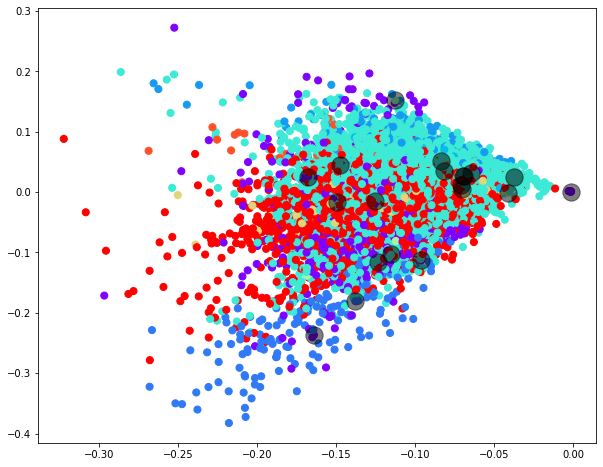

In [18]:
plt.figure(figsize=(10, 8))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=predicted_values, s=50, cmap=cm.rainbow, zorder=1)

plt.scatter(centers[:, 0], centers[:, 1], c='black', s=300, alpha=0.5, zorder=2)